In [166]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from sklearn import preprocessing


# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [197]:
# Importing Dataset
credit=pd.read_csv(r'C:\Users\Raghavi PK\Desktop\PGDDS\capstone project\creditcard.csv')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Checking Class Ratio

In [ ]:
classes=credit['Class'].value_counts()
plt.xlabel("Class label")
plt.ylabel("Number of Occurences")
classes.plot(kind = 'bar',title = 'Class Ratio',rot=0)

This is a highly imbalanced dataset. 

## Exploratory Data Analysis

In [ ]:
credit.describe()

In [ ]:
credit.shape

The dataset contains 31 columns which are PCA transformed. 28 vectors are the result of PCA and its Z scaled. Hence further EDA is not necessary. We will check the vectors for the presence of skewness and also, the amount column which consists of transaction amount will be cleaned. Time column does not give much information, so we are going to ignore it.

In [ ]:
#Train Test split
from sklearn.model_selection import train_test_split
y = credit['Class'] 
X = credit.drop(['Class'], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)

Since data is imbalanced, the train test split is stratified so, the class ratio is considered while splitting the data into train and test sets.

### Transaction Amount

In [ ]:
X_train['Amount'].describe()

In [ ]:
## Checking if any null values present
X_train.isnull().values.any()

In [ ]:
## Checking for the presence of outliers -(histogram and box plot)
plt.figure(figsize=(10,4), dpi=80)
sns.distplot(credit['Amount'], bins=100, kde=False)
plt.ylabel('Count')
plt.title('Transaction Amount')


Data seems to be skewed and outliers are not seen properly.So plotting box plot for it


In [ ]:
plt.figure(figsize=(10,4), dpi=80)
sns.boxplot(credit['Amount'])
plt.title('Transaction Amount')

There are no outliers on the left wheras many on right, so the variable is right skewed. So its skewness is checked.

In [ ]:
#Skewness
X_train['Amount'].skew()

Skewness is really high and its reduced using power transformation.
Box cox transform worksonly on positive data, since Amount contains negative values, it has to be made positive

In [ ]:
X_train.loc[:,'Amount']= X_train['Amount'] + 1e-9

In [ ]:
## Applying Power transform using box cox transform
X_train.loc[:,'Amount'], maxlog, (min_ci, max_ci)=sp.stats.boxcox(X_train['Amount'], alpha=0.01)

#### plotting histogram and box-plot again on Transaction amount to check for the skewness present in the data

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
sns.distplot(X_train['Amount'], bins=100, kde=False)
plt.ylabel('Count')
plt.title('Transaction Amount (Power Transformed)')

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
sns.boxplot(credit['Amount'])
plt.title('Transaction Amount(Power Transformed)')

In [ ]:
X_train['Amount'].skew()

Skewness present in the amount column reduced.

In [ ]:
## Scaling the amount column.
X_train['TransAmnt']=preprocessing.scale(X_train['Amount'])

In [ ]:
X_train.info()

In [ ]:
X_train=X_train.drop('Amount',axis=1)

In [ ]:
X_train.info()

Now analysing the 28 vectors

In [ ]:
vectors_PCA = ['V%i' % j for j in range(1,29)]

In [ ]:
X_train[vectors_PCA].describe()

PCA transformed variables are normally distributed. They dont have any categorical variables.
The vectors are also Z scaled. Skewness is the only factor that needs to be checked.

In [ ]:
## Skewness check
X_train[vectors_PCA].skew()

## Model Building

In [ ]:
## Logistic Regression

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

In [ ]:
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold = LogisticRegression()
results_skfold = cross_val_predict(model_skfold, X_train, y_train, cv=skfold,n_jobs=-1)


In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score, average_precision_score

In [ ]:
print(metrics.roc_auc_score(y_train, results_skfold))

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, results_skfold)

In [ ]:
roc_auc = roc_auc_score(y_train, results_skfold)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

On performing Logistic regression on imbalanced datset, the AUC under ROC obtained is 0.83

Hyperparamter tuning for Logistic Regression

In [199]:
from sklearn.model_selection import GridSearchCV

In [200]:
grid = {'penalty': ['l1', 'l2'], 
              'C': np.logspace(0, 4, 10)}
model = LogisticRegression() 
cv = StratifiedKFold(n_splits=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0) 
grid_result_imb_lr = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result_imb_lr.best_score_, grid_result_imb_lr.best_params_))

Best: 0.971899 using {'C': 1.0, 'penalty': 'l1'}


ROC AUC Score: 0.8255060260392201


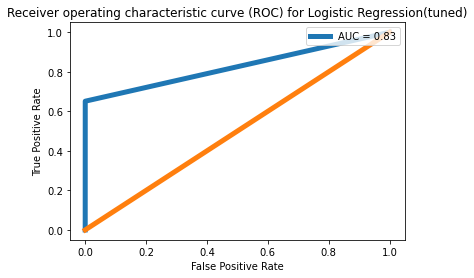

In [201]:
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold = LogisticRegression(C=1,penalty='l1')
results_skfold = cross_val_predict(model_skfold, X_train, y_train, cv=skfold,n_jobs=-1)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, results_skfold)
roc_auc = roc_auc_score(y_train, results_skfold)
print('ROC AUC Score:',roc_auc)

plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Logistic Regression(tuned)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold_dt = DecisionTreeClassifier()
results_skfold_dt = cross_val_predict(model_skfold_dt, X_train, y_train, cv=skfold,n_jobs=-1)

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, results_skfold_dt)

In [ ]:
roc_auc = roc_auc_score(y_train, results_skfold_dt)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Decision trees')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

On performing Decision tree classification on imbalanced datset, the AUC under ROC obtained is 0.88

#### Hyperparameter tuning for Decision trees

In [ ]:
from sklearn.model_selection import GridSearchCV

In [202]:
grid = {'max_depth': [3, None], 
              'max_features': [4,8], 
              'min_samples_leaf': [2,4,8], 
              'criterion': ['gini', 'entropy']} 
   
model = DecisionTreeClassifier() 
cv = StratifiedKFold(n_splits=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0) 
grid_result_imb_dt = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result_imb_dt.best_score_, grid_result_imb_dt.best_params_))

Best: 0.921803 using {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 2}


Best paramtered of Decision tree:
Best: 0.931598 using {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 4}

#### Model Building using tuned factors (Decision Tree)

In [ ]:
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold_dt_tuned = DecisionTreeClassifier(criterion='entropy',max_depth=3,max_features=8,min_samples_leaf=4)
results_skfold_dt_tuned = cross_val_predict(model_skfold_dt_tuned, X_train, y_train, cv=skfold,n_jobs=-1)

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, results_skfold_dt_tuned)

In [ ]:
roc_auc = roc_auc_score(y_train, results_skfold_dt_tuned)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Decision trees with tuning')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

On performing Decision tree classification on imbalanced dataset after hyper parameter tuning, the AUC under ROC obtained is 0.87, which is lower than default condition

#### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold_rf = RandomForestClassifier(warm_start=False,n_jobs=-1)
results_skfold_rf = cross_val_predict(model_skfold_rf, X_train, y_train, cv=skfold,n_jobs=-1)

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, results_skfold_rf)

In [ ]:
roc_auc = roc_auc_score(y_train, results_skfold_rf)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Random forests')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

On performing Random Forest classification on imbalanced datset, the AUC under ROC obtained is 0.895

#### Hyperparameter tuning for Random forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [203]:
model = RandomForestClassifier(warm_start=True)
n_estimators = [10, 30, 50, 100]
max_features = ['auto','sqrt']
max_depth= [4, 8] 
criterion=['gini', 'entropy']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,criterion=criterion)
cv = StratifiedKFold(n_splits=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result_imb_rf = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result_imb_rf.best_score_, grid_result_imb_rf.best_params_))

Best: 0.978466 using {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}


Best features of RF
Best: 0.977854 using {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}

#### Model Building using tuned factors (Random Forest)

In [ ]:
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold_rf_tuned = RandomForestClassifier(criterion='entropy',max_depth=8,max_features='sqrt',n_estimators=100,warm_start=False,n_jobs=-1)
results_skfold_rf_tuned = cross_val_predict(model_skfold_rf_tuned, X_train, y_train, cv=skfold,n_jobs=-1)

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, results_skfold_rf_tuned)

In [ ]:
roc_auc = roc_auc_score(y_train, results_skfold_rf_tuned)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Random forests with tuning')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

On performing Random Forest classification on imbalanced dataset after hyper parameter tuning, the AUC under ROC obtained is 0.90, which is greater than default case as well the highest so far compared to other models(Logistic regression and decision trees)

### Balancing the train dataset

So far modelling was done on imbalanced dataset, now models will be created on balanced dataset.
The balancing techniques ie the oversampling techniques that will be used are SMOTE and ADASYN

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter

In [ ]:
smote = SMOTE(kind='regular',random_state=5)

In [ ]:
X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train)

#### GridSearchCV for Logistic regression on balanced dataset

In [ ]:
grid = {'penalty': ['l1', 'l2'], 
              'C': np.logspace(0, 4, 10)}
model = LogisticRegression() 
cv = StratifiedKFold(n_splits=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0) 
grid_result_bal_lr = grid_search.fit(X_train_smote, y_train_smote)
# summarize results
print("Best: %f using %s" % (grid_result_bal_lr.best_score_, grid_result_bal_lr.best_params_))


In [ ]:
skfold = StratifiedKFold(n_splits=5, random_state=100)
model_skfold_lg_tuned_balanced = LogisticRegression(penalty='l2',C=7.74)
results_skfold_lg_tuned_balanced = cross_val_predict(model_skfold_lg_tuned_balanced, X_train_smote, y_train_smote, cv=skfold,n_jobs=-1)

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train_smote, results_skfold_lg_tuned_balanced)

In [ ]:
roc_auc = roc_auc_score(y_train_smote, results_skfold_lg_tuned_balanced)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Logistic Regression(Balanced)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

0.97 is the AUC score obtained in balanced data set when Logistic regression is performed.

#### GridSearchCV for Decision tree classifier on balanced dataset

In [ ]:
grid = {'max_depth': [3,6,9, None], 
              'max_features': [4,8], 
              'min_samples_leaf': [2,4,8], 
              'criterion': ['gini', 'entropy']} 
   
model = DecisionTreeClassifier() 
cv = StratifiedKFold(n_splits=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0) 
grid_result_bal_dt = grid_search.fit(X_train_smote, y_train_smote)
# summarize results
print("Best: %f using %s" % (grid_result_bal_dt.best_score_, grid_result_bal_dt.best_params_))

In [ ]:
skfold = StratifiedKFold(n_splits=5, random_state=100)
model_skfold_dt_tuned_balanced = DecisionTreeClassifier(criterion='entropy',max_features=8,min_samples_leaf=8)
results_skfold_dt_tuned_balanced = cross_val_predict(model_skfold_dt_tuned_balanced, X_train_smote, y_train_smote, cv=skfold,n_jobs=-1)

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train_smote, results_skfold_dt_tuned_balanced)

In [ ]:
roc_auc = roc_auc_score(y_train_smote, results_skfold_dt_tuned_balanced)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Decision tree classifier(Balanced)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### GridSearchCV for Random forest on balanced dataset

In [ ]:
model = RandomForestClassifier(warm_start=True)
n_estimators = [10, 30, 50, 100]
max_features = ['auto','sqrt']
max_depth= [4, 8] 
criterion=['gini', 'entropy']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,criterion=criterion)
cv = StratifiedKFold(n_splits=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result_bal_rf = grid_search.fit(X_train_smote, y_train_smote)
# summarize results
print("Best: %f using %s" % (grid_result_bal_rf.best_score_, grid_result_bal_rf.best_params_))

In [ ]:
skfold = StratifiedKFold(n_splits=5, random_state=100)
model_skfold_rf_tuned_balanced = RandomForestClassifier(criterion='entropy',max_features='auto',max_depth=8,n_estimators=100)
results_skfold_rf_tuned_balanced = cross_val_predict(model_skfold_rf_tuned_balanced, X_train_smote, y_train_smote, cv=skfold,n_jobs=-1)

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train_smote, results_skfold_rf_tuned_balanced)

In [ ]:
roc_auc = roc_auc_score(y_train_smote, results_skfold_rf_tuned_balanced)
print('ROC AUC Score:',roc_auc)

In [ ]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Random Forest classifier(Balanced)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Prediction on test data after balancing using SMOTE

#### Logistic Regression

In [ ]:
y_pred_lr=grid_result_bal_lr.predict(X_test)

In [ ]:
from sklearn import metrics
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_lr)

In [ ]:
metrics.auc(fp_rate, tp_rate)

AUC for Logistic regression on test data = 0.747

#### Decision tree

In [ ]:
y_pred_dt=grid_result_bal_dt.predict(X_test)

In [ ]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_dt)

In [ ]:
metrics.auc(fp_rate, tp_rate)

AUC for Decision trees on test data = 0.90

#### Random Forest

In [ ]:
y_pred_rf0=grid_result_bal_rf.predict(X_test)

In [ ]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_rf0)

In [ ]:
metrics.auc(fp_rate, tp_rate)

AUC for Random forest on test data = 0.92

In [ ]:
#Precision and Recall values for imbalanced test data
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
confusion = confusion_matrix(y_test,y_pred_rf0)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
precision = confusion[1,1]/(confusion[0,1]+confusion[1,1])
recall = confusion[1,1]/(confusion[1,0]+confusion[1,1])
print('precision for SMOTE balanced train data:',precision)
print('Recall for SMOTE balanced train data:',recall)

After balancing the dataset using SMOTE, the maximum AUC under ROC obtains is 0.92 for random forest model.

### Balancing the test dataset according to evaluation rubrics

In [ ]:
X_test_smote, y_test_smote = smote.fit_sample(X_test,y_test)

## Prediction on balanced test data

#### Logistic Regression

In [ ]:
y_pred_lr1=grid_result_bal_lr.predict(X_test_smote)
from sklearn import metrics
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test_smote, y_pred_lr1)
metrics.auc(fp_rate, tp_rate)

AUC for Logistic regression on test data = 0.8

#### Decision Trees

In [ ]:
y_pred_dt1=grid_result_bal_dt.predict(X_test_smote)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test_smote, y_pred_dt1)
metrics.auc(fp_rate, tp_rate)

AUC for Decision trees on test data = 0.95

#### Random Forest

In [ ]:
y_pred_rf1=grid_result_bal_rf.predict(X_test_smote)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test_smote, y_pred_rf1)
metrics.auc(fp_rate, tp_rate)

AUC for Random forest on test data = 0.98

### Balancing the train dataset using ADASYN technique

In [169]:
ad = ADASYN()
X_ad, y_ad = ad.fit_sample(X_train, y_train)
 
X_ad = pd.DataFrame(data = X_ad, columns = X_train.columns)

print(X_train.shape)
print(X_ad.shape)

(199364, 30)
(397952, 30)


0.8807472158587435


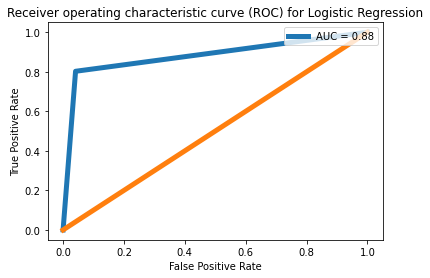

In [170]:
#Modeling with Logistic Regression on ADASYN Balanced train dataset
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold = LogisticRegression()
results_skfold = cross_val_predict(model_skfold, X_ad, y_ad, cv=skfold,n_jobs=-1)
roc_auc = roc_auc_score(y_ad, results_skfold)
print(metrics.roc_auc_score(y_ad, results_skfold))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_ad, results_skfold)
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC AUC Score: 0.9022638454920575


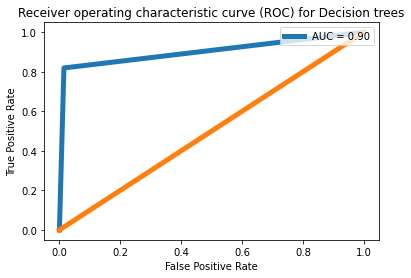

In [171]:
#Modeling with Decision Trees on ADASYN balanced train dataset
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold_dt = DecisionTreeClassifier()
results_skfold_dt = cross_val_predict(model_skfold_dt, X_ad, y_ad, cv=skfold,n_jobs=-1)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_ad, results_skfold_dt)
roc_auc = roc_auc_score(y_ad, results_skfold_dt)
print('ROC AUC Score:',roc_auc)
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Decision trees')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC AUC Score: 0.9017732910504227


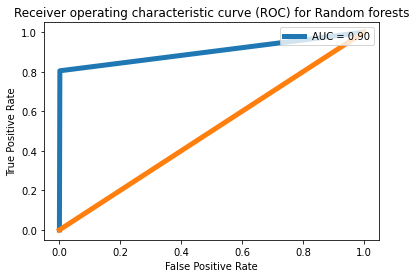

In [172]:
#Modeling with Random Forests on ADASYN balanced train dataset
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold_rf = RandomForestClassifier(warm_start=False,n_jobs=-1)
results_skfold_rf = cross_val_predict(model_skfold_rf, X_ad, y_ad, cv=skfold,n_jobs=-1)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_ad, results_skfold_rf)
roc_auc = roc_auc_score(y_ad, results_skfold_rf)
print('ROC AUC Score:',roc_auc)
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Random forests')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Hyperparameters tuning to see if the AUC increases after tuning for each models

#### GridSearchCV for Logistic regression on ADASYN balanced train dataset

In [173]:
grid = {'penalty': ['l1', 'l2'], 
              'C': np.logspace(0, 4, 10)}
model = LogisticRegression() 
cv = StratifiedKFold(n_splits=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0) 
grid_result_test_bal_lr_ada = grid_search.fit(X_ad, y_ad)
# summarize results
print("Best: %f using %s" % (grid_result_test_bal_lr_ada.best_score_, grid_result_test_bal_lr_ada.best_params_))

Best: 0.954573 using {'C': 10000.0, 'penalty': 'l1'}


In [174]:
skfold_test = StratifiedKFold(n_splits=5, random_state=100)
model_skfold_lg_tuned_balanced_test = LogisticRegression(penalty='l1',C=7.74)
results_skfold_lg_tuned_balanced_test = cross_val_predict(model_skfold_lg_tuned_balanced_test, X_ad, y_ad, cv=skfold_test,n_jobs=-1)

In [175]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_ad, results_skfold_lg_tuned_balanced_test)

In [176]:
roc_auc = roc_auc_score(y_ad, results_skfold_lg_tuned_balanced_test)
print('ROC AUC Score:',roc_auc)

ROC AUC Score: 0.9001452659725292


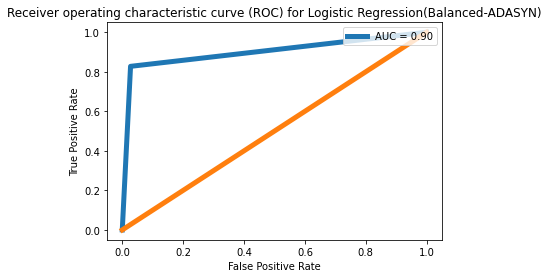

In [177]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.2f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Logistic Regression(Balanced-ADASYN)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### GridSearchCV for Decision Tress on ADASYN balanced train dataset

In [178]:
grid = {'max_depth': [3,6,9, None], 
              'max_features': [4,8], 
              'min_samples_leaf': [2,4,8], 
              'criterion': ['gini', 'entropy']} 
   
model = DecisionTreeClassifier() 
cv = StratifiedKFold(n_splits=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0) 
grid_result_bal_dt_ada = grid_search.fit(X_ad, y_ad)
# summarize results
print("Best: %f using %s" % (grid_result_bal_dt_ada.best_score_, grid_result_bal_dt_ada.best_params_))

Best: 0.930797 using {'criterion': 'entropy', 'max_depth': 9, 'max_features': 8, 'min_samples_leaf': 4}


In [179]:
skfold = StratifiedKFold(n_splits=5, random_state=100)
model_skfold_dt_tuned_balanced = DecisionTreeClassifier(criterion='gini',max_depth=9,max_features=8,min_samples_leaf=2)
results_skfold_dt_tuned_balanced = cross_val_predict(model_skfold_dt_tuned_balanced, X_ad, y_ad, cv=skfold,n_jobs=-1)

In [180]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_ad, results_skfold_dt_tuned_balanced)

In [181]:
roc_auc = roc_auc_score(y_ad, results_skfold_dt_tuned_balanced)
print('ROC AUC Score:',roc_auc)

ROC AUC Score: 0.8618629906674206


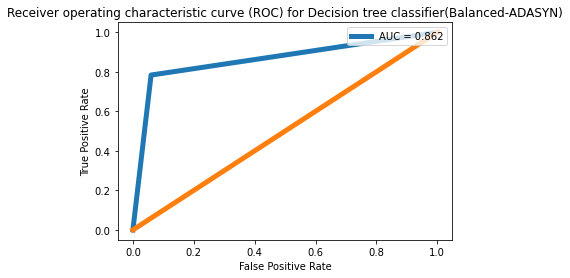

In [182]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Decision tree classifier(Balanced-ADASYN)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### GridSearchCV for Random forest on ADASYN balanced train dataset

In [183]:
model = RandomForestClassifier(warm_start=True)
n_estimators = [10, 30, 50, 100]
max_features = ['auto','sqrt']
max_depth= [4, 8] 
criterion=['gini', 'entropy']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,criterion=criterion)
cv = StratifiedKFold(n_splits=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result_bal_rf_ada = grid_search.fit(X_ad, y_ad)
# summarize results
print("Best: %f using %s" % (grid_result_bal_rf_ada.best_score_, grid_result_bal_rf_ada.best_params_))

Best: 0.965587 using {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}


In [184]:
skfold = StratifiedKFold(n_splits=5, random_state=100)
model_skfold_rf_tuned_balanced = RandomForestClassifier(criterion='entropy',max_features='auto',max_depth=8,n_estimators=100)
results_skfold_rf_tuned_balanced = cross_val_predict(model_skfold_rf_tuned_balanced, X_ad, y_ad, cv=skfold,n_jobs=-1)

In [185]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_ad, results_skfold_rf_tuned_balanced)
roc_auc = roc_auc_score(y_ad, results_skfold_rf_tuned_balanced)
print('ROC AUC Score:',roc_auc)

ROC AUC Score: 0.8835779007543736


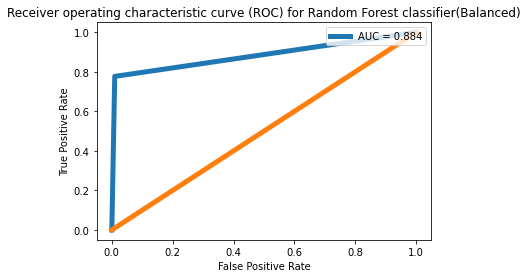

In [186]:
plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'%roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.legend(loc='upper right')
plt.title('Receiver operating characteristic curve (ROC) for Random Forest classifier(Balanced)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

AUC is 0.884 for Random Forest algorithm on ADASYN balanced train dataset

### Prediction of ADASYN balanced test data

In [206]:
#Logistic Regression
y_pred_lr_ada=grid_result_test_bal_lr_ada.predict(X_test)
from sklearn import metrics
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_lr_ada)
print('Logistic Regression AUC is:',metrics.auc(fp_rate, tp_rate))

#Decision Tree
y_pred_dt_ada=grid_result_bal_dt_ada.predict(X_test)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_dt_ada)
print('Decision Trees AUC is:',metrics.auc(fp_rate, tp_rate))

#Random Forest
y_pred_rf_ada=grid_result_bal_rf_ada.predict(X_test)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_rf_ada)
print('Random Forest AUC is:',metrics.auc(fp_rate, tp_rate))

Logistic Regression AUC is: 0.7440554086532749
Decision Trees AUC is: 0.8989214696847032
Random Forest AUC is: 0.9390346381318888


### Balancing of the test data using ADASYN Technique

In [192]:
ad = ADASYN()
X_ad_test, y_ad_test = ad.fit_sample(X_test, y_test)
 
print(X_test.shape)
print(X_ad_test.shape)

(85443, 30)
(170578, 30)


### Predict against the ADASYN balanced test data

In [207]:
#Logistic Regression
y_pred_lr_ada1=grid_result_test_bal_lr_ada.predict(X_ad_test)
from sklearn import metrics
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_ad_test, y_pred_lr_ada1)
print('Logistic Regression AUC is:',metrics.auc(fp_rate, tp_rate))

#Decision Tree
y_pred_dt_ada1=grid_result_bal_dt_ada.predict(X_ad_test)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_ad_test, y_pred_dt_ada1)
print('Decision Trees AUC is:',metrics.auc(fp_rate, tp_rate))

#Random Forest
y_pred_rf_ada1=grid_result_bal_rf_ada.predict(X_ad_test)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_ad_test, y_pred_rf_ada1)
print('Random Forest AUC is:',metrics.auc(fp_rate, tp_rate))

Logistic Regression AUC is: 0.7294462980006973
Decision Trees AUC is: 0.8543240862829858
Random Forest AUC is: 0.8741200817946574


### Prediction on imbalanced dataset

In [208]:
#Logistic Regression
y_pred_lr_imb=grid_result_test_bal_lr_ada.predict(X_test)
from sklearn import metrics
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_lr_imb)
print('Logistic Regression AUC is:',metrics.auc(fp_rate, tp_rate))

#Decision Tree
y_pred_dt_imb=grid_result_bal_dt_ada.predict(X_test)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_dt_imb)
print('Decision Trees AUC is:',metrics.auc(fp_rate, tp_rate))

#Random Forest
y_pred_rf_imb=grid_result_bal_rf_ada.predict(X_test)
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_rf_imb)
print('Random Forest AUC is:',metrics.auc(fp_rate, tp_rate))

Logistic Regression AUC is: 0.7440554086532749
Decision Trees AUC is: 0.8989214696847032
Random Forest AUC is: 0.9390346381318888


### Precision and recall on Random forest for SMOTE and ADASYN

In [204]:
#Precision and Recall values for all the datasets
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
#Precision and Recall values for ADASYN balanced test data on Random Forest
confusion = confusion_matrix(y_ad_test,y_pred_rf_ada1)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
precision = confusion[1,1]/(confusion[0,1]+confusion[1,1])
recall = confusion[1,1]/(confusion[1,0]+confusion[1,1])
print('Precision for ADASYN balanced test data:',precision)
print('Recall for ADASYN balanced test data:',recall)

Precision for ADASYN balanced test data: 0.9821822578207647
Recall for ADASYN balanced test data: 0.762062779217429


In [196]:
#Precision and Recall values for SMOTE balanced test data
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
confusion = confusion_matrix(y_test_smote,y_pred_rf1)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
precision = confusion[1,1]/(confusion[0,1]+confusion[1,1])
recall = confusion[1,1]/(confusion[1,0]+confusion[1,1])
print('Precision for SMOTE balanced train data:',precision)
print('Recall for SMOTE balanced train data:',recall)

precision for SMOTE balanced train data: 0.9884161677707323
Recall for SMOTE balanced train data: 0.9813705375461633


### Classification of values for each datasets
AUC under ROC obtained on training data are as follows for three different models.

| Model | Imbalanced data Hypertuned model | SMOTE Balanced train data | ADASYN Balanced train data | 
| --- | --- | --- | --- | 
| Logistic Regression AUC | 0.83 | 0.97 | 0.90 |  
| Decision Trees AUC | 0.87 | 0.99 | 0.86 | 
| Random Forest AUC | 0.90 | 0.98 | 0.88 | 

### Predictions and metrics towards test data

| Model | Predicted values of imbalanced dataset |Predicted values on SMOTE balanced dataset(without balancing test train)| Predicted values on SMOTE balanced dataset(with balancing test train) | Predicted values on ADASYN balanced dataset(without balancing test train) |Predicted values on ADASYN balanced dataset(with balancing test train)|
| --- | --- | --- | --- | ---|--- |
| Logistic Regression AUC | 0.74 | 0.74 | 0.8 | 0.74 | 0.72 |
| Decision Trees AUC | 0.89 | 0.90 | 0.95 | 0.89 | 0.85 |
| Random Forest AUC | 0.93 | 0.92 | 0.98 | 0.93 | 0.87 |


### Conclusion

-  The above meterics are tabulated which gives the area under the ROC curve for each model consider i.e., Logistic regression, decision trees and random forests
- Initially these models are applied to imbalanced dataset which gave 90% on ROC-AUC for random forests. From this an insight could be obtained that Random forest performs better even if the data is imbalanced
- Then data is balanced using 2 techniques called SMOTE and ADASYN
- The test data is predicted against several scenarios such as imbalanced data, SMOTE balanced data and ADASYN imbalanced data. Table 2 given above, gives ROC-AUC for all these scenarios
- In general test data need not be balanced , but based on the evaluation rubrics, results were obtained for both balanced and unbalanced test data 
- From the above metrics Random forest performs well on both balanced and imbalanced data set.
- Specifically, even when test data is not balanced, the predicted ROC-AOC obtained is 92 % on SMOTE balanced (train) random forest model whereas ADASYN balanced random forest model gave 93 % ROC-AUC score.
- When test data is also balanced, SMOTE on random forest gave the maximum ROC-AUC of 98 % compared to other models thus concluding that SMOTE balanced Random forest model outperformed other models taken into consideration for this project.